# Non-juvenile undersampling

In [10]:
library(ggplot2)
library(data.table)
library(reshape)


Attaching package: ‘reshape’


The following object is masked from ‘package:data.table’:

    melt




*NOTE: This is a condensed version of [this HTML document](model_selection.html) and the official homework submission. I only present the high-level results and code here and only some bibliographic references are shown. Wherever appropriate I refer to the more comprehensive version for details. For a better reading experience I much recommend using the HTML document. If you are reading this from Jupyter, note that the HTML may note render well, so I recommend downloading and opening it in your default browser instead.'*

This note investigates if and how systematic sub-sampling in situations where $n>>p$ can be applied to imbalanced learning. It is structured as follows: to set the stage for the final investigation we first briefly recap the bias-variance trade-off. We then introduce various subsampling methods for linear regression and subsequently illustrate the improvements associated with non-uniform subsampling. Finally the developed ideas are applied to binary classification problems with imbalanced training data.

## Bias-variance tradeoff

Recall that for the mean-squared error (MSE) we have 

$$
\begin{equation} 
\begin{aligned}
&& \mathbb{E} \left( (\hat{f}_n(x)-f(x))^2 \right)
&= \text{var} (\hat{f}_n(x)) + \left( \mathbb{E} \left( \hat{f}_n(x) \right) - f(x) \right)^2 \\
\end{aligned}
\end{equation}
$$

where the first term on the right-hand side corresponds to the variance of our prediction and the second term to its (squared) bias. Bishop shows how increasing model complexity increases the former and decreases the latter (see [HTML](model_selection.html) for details).  Bishops demonstrates this through regularization (in particular Ridge regression), but the results could similarly be established by using OLS and letting the number of Gaussian kernels vary and hence the number of features $p$ where higher values of $p$ correspond to increased model complexity.

The focus of this note is instead on varying the sample size $n$. It should not be surprising that both the variance and bias component of the MSE decrease as the sample size $n$ increases (see figure below). But in today's world $n$ can potentially be very large, so much so that even computing simple linear models can be hard. Suppose for example you wanted to use patient data that is generated in real-time as a global pandemic unfolds to predict the trajectory of said pandemic. Or consider the vast quantities of potentially useful user generated data that online service providers have access to. In the remainder of this note we will investigate how systematic subsampling can help improve model accuracy in these situations.

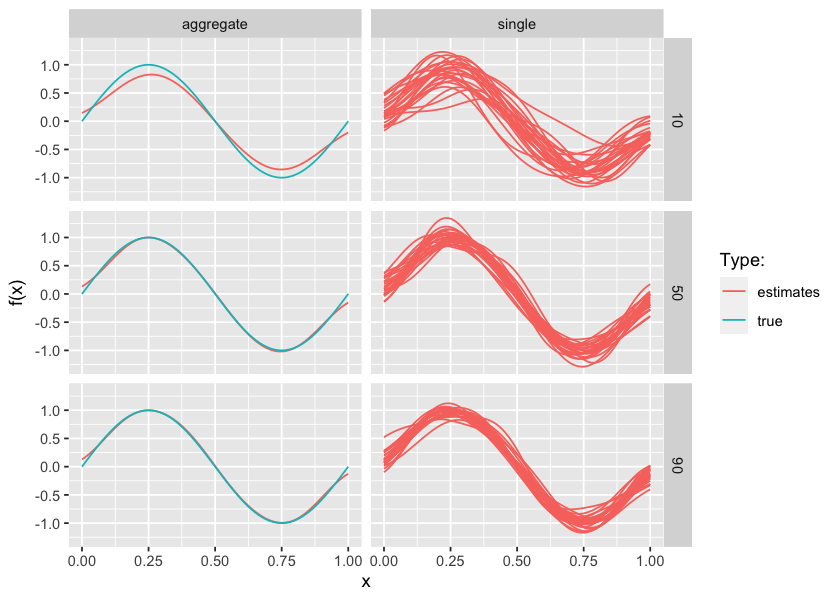

In [16]:
source("R/gauss_kernel.R")
source("R/sinusoidal.R")
source("R/sim_sinusoidal.R")
source("R/regularized_ls.R")
# Generate data: ----
n <- 100
m <- c(0.10, 0.5, 0.90)
a <- 0
b <- 1
x <- seq(a,b,length.out = n)
y <- sinusoidal(x)
p <- 24
x <- seq(a,b,length.out = n)
y <- sinusoidal(x)
v <- 0.3
s <- 0.1
n_draws <- 100
mu <- seq(a,b,length.out = p)
lambda <- exp(-0.31)
Phi <- cbind(
  1,
  sapply(
    1:length(mu),
    function(p) {
      mu_p <- mu[p]
      gauss_kernel(x=x, mu=mu_p, s = s)
    }
  )
)
# Run simulation:
dt <- rbindlist(
  lapply( # loop - draw K times
    1:n_draws,
    function(k) {
      rbindlist(
        lapply( # loop over sample sizes:
          1:length(m),
          function(t) {
            n_sample <- m[t] * n
            # Draw:
            simulated <- sim_sinusoidal(n=n_sample, sigma = v)
            y_k <- simulated$y_star
            x_k <- simulated$x_star
            # Extract features:
            Phi_k <- cbind(
              1,
              sapply(
                1:length(mu),
                function(p) {
                  mu_p <- mu[p]
                  gauss_kernel(x=x_k, mu=mu_p, s = s)
                }
              )
            )
            beta_hat <- regularized_ls(Phi_k,y_k,lambda) # fit model on (y,x)
            y_hat <- c(Phi %*% beta_hat) # predict from model
            dt <- data.table(value=y_hat,draw=k,sample_size=n_sample,n=1:n,x=x)
            return(dt)
          }
        )
      )
    }
  )
)
dt[,facet_group:="single"]
dt[,colour_group:="estimates"]
# Expected values:
dt_exp = dt[,.(value=mean(value)),by=.(sample_size,n,x)]
dt_exp[,facet_group:="aggregate"]
dt_exp[,colour_group:="estimates"]
dt_exp[,draw:=1] # just for aesthetics
# True values:
library(reshape)
dt_true = data.table(expand.grid.df(data.frame(value=y,x=x),data.frame(sample_size=m*n)))
dt_true[,facet_group:="aggregate"]
dt_true[,colour_group:="true"]
dt_true[,draw:=2] # just for aesthetics
# Plot data:
dt_plot = rbind(
  dt,
  dt_exp,
  dt_true,
  fill=T
)
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(data=dt_plot[draw<=25], aes(y=value, x=x, colour=colour_group, group=draw)) +
  geom_line() +
  facet_grid(
    rows = vars(sample_size),
    cols = vars(facet_group)
  ) +
  scale_color_discrete(
    name="Type:"
  ) +
  labs(
    y = "f(x)"
  )

## Sub-sampling methods

In [4]:
source("R/rorthogonal.R")
source("R/sim_subsampling.R")
n <- 1000
m <- 10

The case for sub-sampling generally involves $n >> p$, so very large values of $n$. In such cases we may be interested in estimating $\hat\beta_m$ instead of $\hat\beta_m$ where $p\le m=`r m`<<n$ with $m$ freely chosen by us. In practice we may want to do this to avoid high computational costs associated with large $n$ as discussed above. The basic algorithm for estimating $\hat\beta_m$ is simple:

1. Subsample with replacement from the data with some sampling probability $\{\pi_i\}^n_{i=1}$.
2. Estimate least-squares estimator $\hat\beta_m$ using the subsample. 

But there are at least two questions about this algorithm: firstly, how do we choose $X_m=x^{(1)},...,x^{(m)}$? Secondly, how should we construct $\hat\beta_m$? With respect to the former, a better idea than just randomly selecting $X_m$ might be to choose observations with high influence. We will look at a few of the different subsampling methods investigated and proposed in Zhu et al, which differ primarily in their choice of subsampling probabilities $\{\pi_i\}^n_{i=1}$:

1. Uniform subsampling (UNIF): $\{\pi_i\}^n_{i=1}=1/n$.
2. Basic leveraging (BLEV): $\{\pi_i\}^n_{i=1}=h_{ii}/ \text{tr}(\mathbb{H})=h_{ii}/p$ where $\mathbb{H}$ is the *hat matrix*.
3. Optimal (OPT) and predictor-length sampling (PL): involving $||x_i||/ \sum_{i=1}^{n}||x_i||$ where $||x||$ denotes the $L_2$ norm of $x$.

Methods involving predictor-lengths are proposed by the authors with the former shown to be optimal (more on this below). PL subsampling is shown to scale very well and a good approximation of optimal subsampling conditional on leverage scores $h_{ii}$ being fairly homogeneous.

With respect to the second question Zhu et al investigate both ordinary least-squares (OLS) and weighted least-squares (WLS), where weights simply correspond to subsampling probabilities $\{\pi_i\}^n_{i=1}$. The authors present empirical evidence that OLS is more efficient than WLS in that the mean-squared error (MSE) for predicting $\Phi \beta$ is lower for OLS. The authors also note though that subsampling using OLS is not consistent for non-uniform subsampling methods meaning that the bias cannot be controlled. Given the equation for the MSE above the fact that OLS is nonetheless more efficient than WLS implies that the higher variance terms associated with WLS dominates the effect of relatively higher bias with OLS. In fact this is consistent with the theoretical results presented in Zhu et al (more on this below).

Next we will briefly run through different estimation and subsampling methods in some more detail and see how they can be implemented in R. In the following section we will then look at how the different approaches perform empirically.

### OLS and WLS

Both OLS and WLS are implemented here using QR decomposition. The details are skipped here but can be found in the [HTML](model_selection.html). The helper function is loaded below.

In [5]:
source("R/wls_qr.R")

### Subsampling methods

Again some details are skipped here but can be found in the [HTML](model_selection.html). Helper functions for the different methods are sourced below. 

In [8]:
source("R/UNIF.R")
source("R/BLEV.R")
source("R/OPT.R")
source("R/PL.R")

*A note on computing leverage scores*:

Recall that for the *hat matrix* we have

$$
\begin{equation} 
\begin{aligned}
&& \mathbb{H}&=\Phi (\Phi^T \Phi)^{-1}\Phi^T \\
\end{aligned}
\end{equation}
$$

where the diagonal elements $h_{ii}$ correspond to the leverage scores we're after. Following Zhu et al we will use (compact) singular value decomposition to obtain $\mathbb{H}$ rather than computing the above equation directly. For a derivation of this result see the [HTML](model_selection.html).

*A note on optimal subsampling:*

The basic characteristic of PL subsampling - choosing $\{\pi_i\}^n_{i=1}= ||x_i||/ \sum_{j=1}^{n}||x_j||$ - was already introduced above.
In fact, PL subsampling is an approximate version of optimal subsampling (OPT). Zhu et al show that variance $V=\text{var} (\hat{f}_n(x))$ dominates squared bias $\left( \mathbb{E} \left( \hat{f}_n(x) \right) - f(x) \right)^2$. More specifically they show that asymptotically we have:

$$
\begin{equation} 
\begin{aligned}
&&\text{plim} \left( \text{var} (\hat{f}_n(x)) \right) > \text{plim} \left(\left( \mathbb{E} \left( \hat{f}_n(x) \right) - f(x) \right)^2 \right)  \\
\end{aligned}
(\#eq:plim)
\end{equation}
$$

Given this result minimizing the MSE with respect to subsampling probabilities $\{\pi_i\}^n_{i=1}$ corresponds to minimizing $V$. They further show that this minimization problem has the following closed-form solution:

$$
\begin{equation} 
\begin{aligned}
&& \pi_i&= \frac{\sqrt{(1-h_{ii})}||x_i||}{\sum_{j=1}^n\sqrt{(1-h_{jj})}||x_j||}\\
\end{aligned}
(\#eq:opt)
\end{equation}
$$

This still has computational costs of order $\mathcal{O}(np^2)$. It should now be straight-forward to see why PL subsampling is optimal conditional on leverage scores being homogeneous (see [HTML](model_selection.html) for details). PL subsampling is associated with computational costs of order $\mathcal{O}(np)$ so a great improvement.

*A note on sampling probabilities:*

As discussed in Zhu et al both OPT and PL subsampling tend to inflate subsampling probabilities of observations with low leverage scores and shrink those of high-leverage observations relative to BLEV. They show explicitly that this always holds for orthogonal design matrices. As a quick sense-check of the functions introduced above we can generate a random orthogonal design matrix $X$ and plot subsampling probabilities with OPT and PL against those obtained with BLEV. The figure below illustrates this relationship nicely. Generating random orthogonal matrices can be done easily through SVD (see [this helper function](R/rorthogonal.R)).

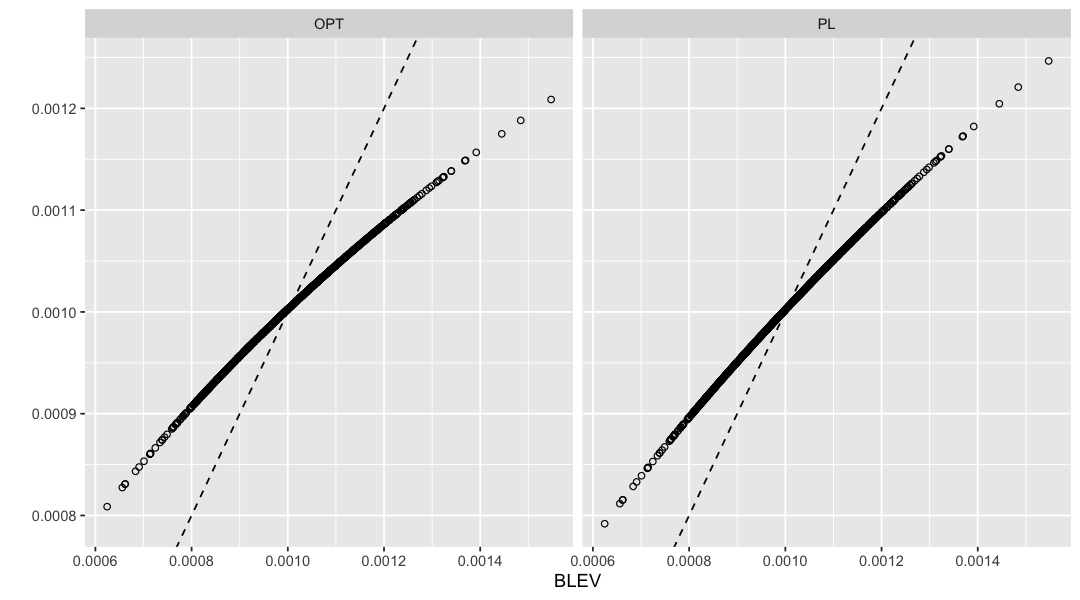

In [21]:
source("R/rorthogonal.R")
n <- 1000
p <- 100
X <- rorthogonal(n,p)
# Subsampling methods:
methods <- list(
  "UNIF" = UNIF,
  "BLEV" = BLEV,
  "OPT" = OPT,
  "PL" = PL
)
smpl_probs <- rbindlist(
  lapply(
    names(methods)[2:4],
    function(i) {
      method <- i
      prob <- methods[[method]](X, y=NULL, m=NULL, prob_only=T)
      return(data.table(prob=prob, method=method))
    }
  )
)
dt_plot <- rbindlist(
  lapply(
    names(methods)[3:4],
    function(i) {
      other_method <- i
      x <- smpl_probs[method=="BLEV"]$prob
      y <- smpl_probs[method==other_method]$prob
      data.table(x=x, y=y, y_var=other_method)
    }
  )
)
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(dt_plot, aes(x=x, y=y)) +
  geom_abline(intercept = 0, slope=1, linetype="dashed") +
  geom_point(shape=1) +
  facet_grid(
    cols=vars(y_var)
  ) +
  labs(
    x="BLEV",
    y=""
  )

## Linear regression

To illustrate the improvements associated with the methods proposed in Zhu et al, we will briefly replicate their main empirical findings here. To evaluate the performance of the different methods we will proceed as follows:

**Empirical exercise**

1. Generate synthetic data $X$ of dimension $(n \times m)$ with $n>>m$. 
2. Set some true model parameter $\beta=(\mathbf{1}^T_{\overline{m*0.6}},\mathbf{1}^T_{\underline{m*0.4}})^T$.
3. Model the outcome variables as $y=X\beta+\epsilon$ where $\epsilon \sim \mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I}_n)$ and $\sigma=10$.
4. Estimate the full-sample OLS estimator $\hat\beta_n$ (a benchmark estimator of sorts in this setting).
5. Use one of the subsampling methods to estimate iteratively $\{\hat\beta^{(b)}_m\}^B_{b=1}$. Note that all subsampling methods are stochastic so $\hat\beta_m$ varies across iterations.
6. Evaluate average model performance of $\hat\beta_m$ under the mean-squared error criterium: $MSE= \frac{1}{B} \sum_{b=1}^{B} MSE^{(b)}$ where $MSE^{(b)}$ corresponds to the in-sample estimator of the mean-squared error of the $b$-th iteration.

This exercise - and the once that follow - are computationally expensive. For them to be feasible we have to refrain from bias-correcting the in-sample estimator of the MSE. In R we will use a simple [wrapper function](R/sim_subsampling.R) to run the empirical exercise.

As in Zhu et al we will generate the design matrix $X$ from 5 different distributions: 1) Gaussian (GA) with $\mathcal{N}(\mathbf{0},\Sigma)$; 2) Mixed-Gaussian (MG) with $0.5\mathcal{N}(\mathbf{0},\Sigma)+0.5\mathcal{N}(\mathbf{0},25\Sigma)$; 3) Log-Gaussian (LN) with $\log\mathcal{N}(\mathbf{0},\Sigma)$; 4) T-distribution with 1 degree of freedom (T1) and $\Sigma$; 5) T-distribution as in 4) but truncated at $[-p,p]$. All parameters are chosen in the same way as in @zhu2015optimal with exception of $n=`r n`$ and $p=`r p`$, which are significantly smaller choices in order to decrease the computational costs. The corresponding densities of the 5 data sets can be found in the appendix of the [HTML](model_selection.html).

In [19]:
# Generate synthetic data ----
n <- 1000
p <- 3
set.seed(1)
library(expm)
matrix_grid <- expand.grid(i=1:p,j=1:p)
Sigma <- matrix(rep(0,p^2),p,p)
for (x in 1:nrow(matrix_grid)) {
  i <- matrix_grid$i[x]
  j <- matrix_grid$j[x]
  Sigma[i,j] <- 2 * (0.8)^(abs(i-j))
}
# 1.) Design matrix (as in Zhu et al): ----
GA <- matrix(rnorm(n*p), nrow = n, ncol = p) %*% sqrtm(t(Sigma))
# Gaussian mixture:
gaus_mix <- list(
  gaus_1 = matrix(rnorm(n*p), nrow = n, ncol = p) %*% sqrtm(t(Sigma)),
  gaus_2 = matrix(rnorm(n*p), nrow = n, ncol = p) %*% sqrtm((25 * t(Sigma)))
)
MG <- matrix(rep(0,n*p),n,p)
for (i in 1:nrow(MG)) {
  x <- sample(1:2,1)
  MG[i,] <- gaus_mix[[x]][i,]
}
# Log-Gaussian:
LN <- exp(GA)
# T-distribution:
T1 <- matrix(rt(n*p,1), nrow = n, ncol = p) %*% sqrtm(t(Sigma))
# Truncated T:
TT <- T1
TT[TT>p] <- p
TT[TT<(-p)] <- -p
data_sets <- list(
  GA = list(X = GA),
  MG = list(X = MG),
  LN = list(X = LN),
  TT = list(X = TT),
  T1 = list(X = T1)
)
# 2.) Outcome:
data_sets <- lapply(
  data_sets,
  function(i) {
    X <- i[["X"]]
    beta <- c(rep(1,ceiling(0.6*p)),rep(0.1,floor(0.4*p)))
    eps <- rnorm(n=n,mean=0,sd=10)
    y <- X %*% beta + eps
    list(X=X, y=y)
  }
)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand



Attaching package: ‘expm’


The following object is masked from ‘package:Matrix’:

    expm




We will run the empirical exercise for each data set and each subsampling method introduced above. The figure below shows logarithms of the sampling probabilities corresponding to the different subsampling methods (UNIF not shown for obvious reasons; for details on how the sampling probabilities are computed using the functions introduced above see [HTML](model_selection.html)). The plots look very similar to the one in Zhu et al and is shown here primarily to reassure ourselves that we have implemented their ideas correctly. One interesting observation is worth pointing out however: note how the distributions for OPT and PL have lower standard deviations compared to BLEV. This should not be altogether surprising since we already saw above that for orthogonal design matrices the former methods inflate small leverage scores while shrinking high scores. But it is interesting to see that the same appears to hold for design matrices that are explicitly not orthogonal given our choice of $\Sigma$.

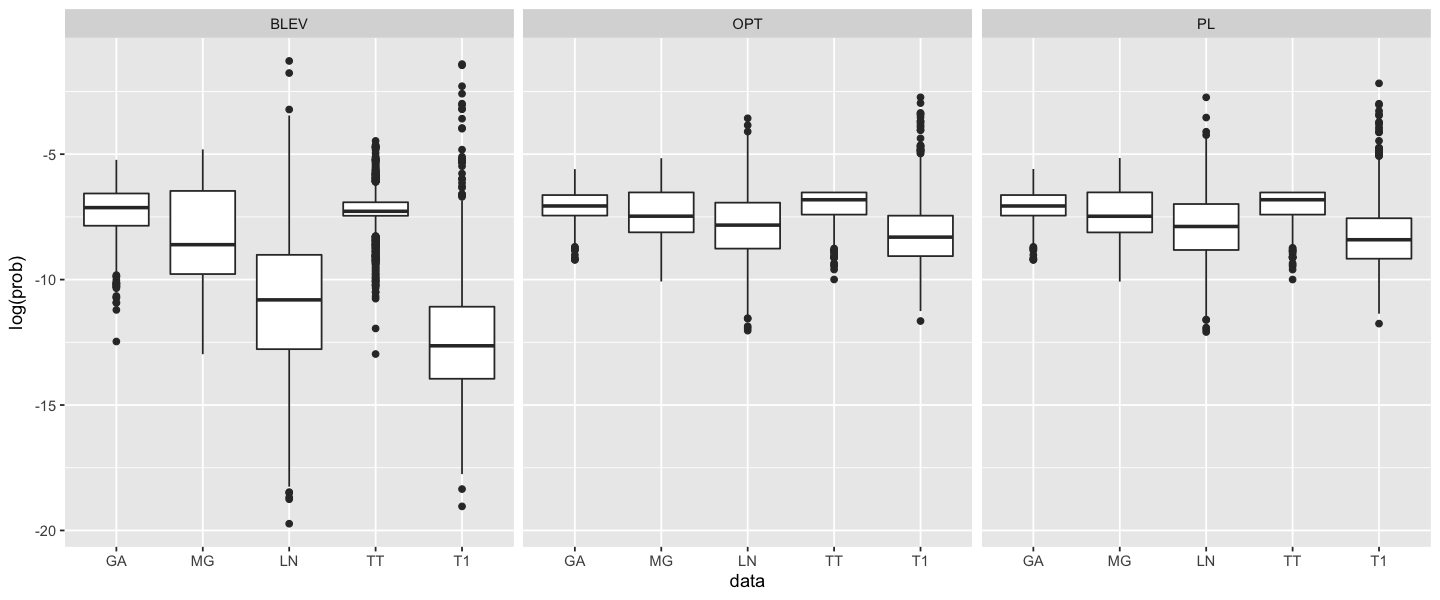

In [24]:
smpl_probs <- readRDS("outputs/smpl_probs.rds")
options(repr.plot.width = 12, repr.plot.height = 5)
ggplot(
  data = smpl_probs,
  aes(x=data, y=log(prob)) 
) +
  geom_boxplot() +
  facet_grid(
    col=vars(method)
  )

The code below runs the empirical exercise. It is intentionally commented out as it takes a long time to compute. If you want to run it make sure you know how to interrupt your kernel.

In [30]:
# Simulation parameters:
# n <- 1000 
# p <- 3
# m <- c()
# counter <- 1
# max_ratio <- 0
# while(length(m)<7 & max_ratio<.1) {
#   temp <- max(p,(2^(counter)*1e-3) * n)
#   m <- unique(c(m, temp))
#   max_ratio <- max(m/n)
#   counter <- counter + 1
# }
# weighted <- c(T,F)
# pgrid <- data.table(
#   expand.grid(
#     m=m, 
#     method=names(methods), 
#     weighted=weighted, 
#     data_set=names(data_sets)
#   )
# )
# set.seed(1)
# grid_search <- rbindlist(
#   lapply(
#     1:nrow(pgrid),
#     function(i) {
#       m <- pgrid[i,m]
#       estimator_name <- pgrid[i,method] 
#       estimator <- methods[[estimator_name]]
#       weighted <- pgrid[i, weighted]
#       data_set <- pgrid$data[i]
#       X <- data_sets[[data_set]]$X
#       y <- data_sets[[data_set]]$y
#       output <- sim_subsampling(X, y, m, estimator, weighted=weighted)
#       output[,m:=m]
#       output[,method:=estimator_name]
#       output[,weighted:=weighted]
#       output[,data_set:=data_set]
#     }
#   )
# )
# grid_search[,weighted:=factor(weighted)]
# levels(grid_search$weighted) <- c("OLS","WLS")
# grid_search[,log_value:=log(value)]

The two figures below show the resulting MSE, squared bias and variance for the different subsampling methods and data sets using weighed least-squares and ordinary least-squares, respectively. The subsampling size increases along the horizontal axis. 

For the data sets that are also shown in Zhu et al we find the same overall pattern: PL and OPT outperform other methods when using weighted least-squares, while BLEV outperforms other methods when using unweighted/ordinary least-squares. 

For Gaussian data (GA) the differences between the methods are minimal since data points are homogeneous. In fact, Zhu et al recommend to just rely on uniform subsampling when data is Gaussian. Another interesting observations is that for t-distributed data (T1) the non-uniform subsampling methods significantly outperform uniform subsampling methods. This is despite the fact that in the case of T1 data the conditions used to establish asymptotic consistency of the non-uniform subsampling methods in Zhu et al are not fulfilled: in particular the fourth moment is not finite (in fact it is not defined). This is curious: even though we may not want to use subsampling at all if this condition is not met, we should at least employ non-uniform subsampling if we really do have to estimate $\beta$ through subsampling.

$OLS

$WLS


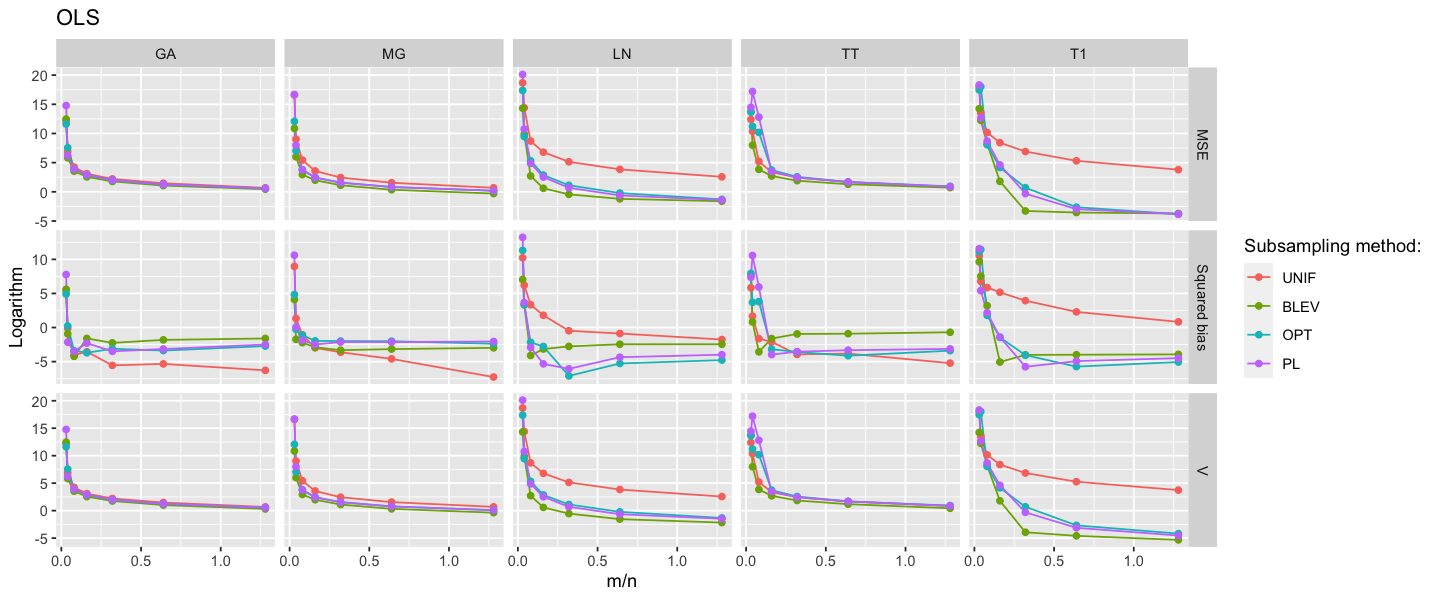

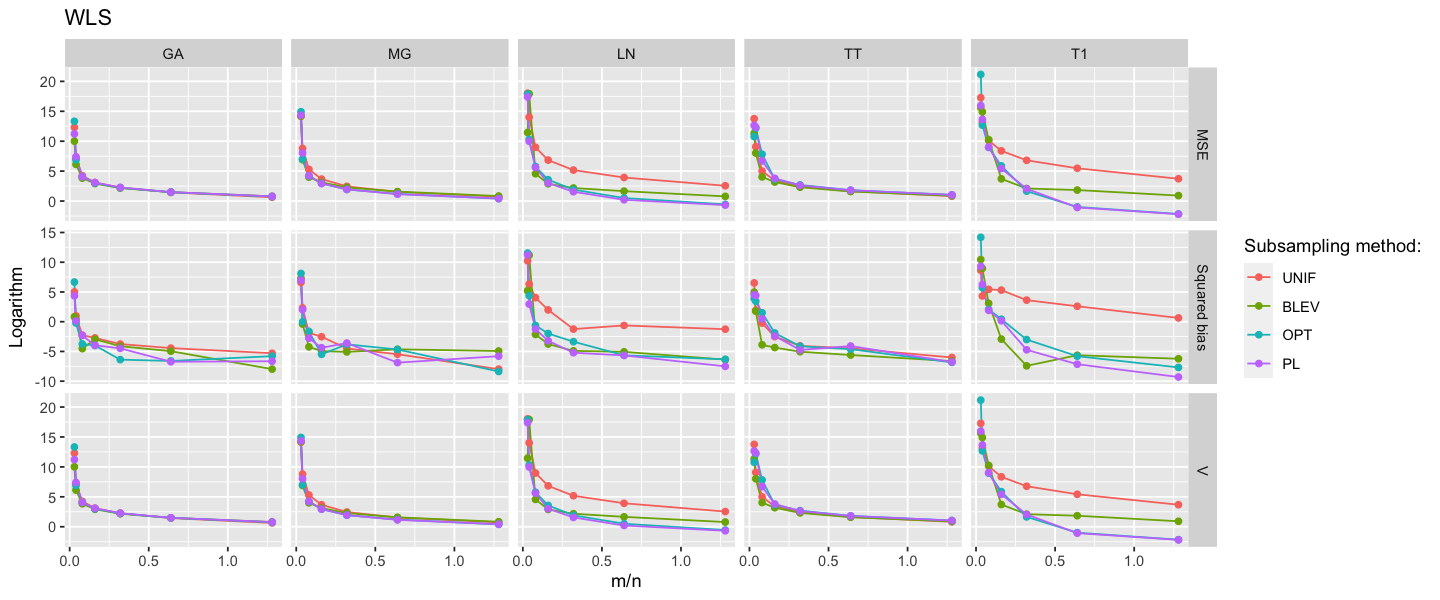

In [31]:
grid_search <- readRDS("outputs/grid_search_zhu.rds")
p_list <- lapply(
  1:2,
  function(i) {
    ggplot(
      data=grid_search[weighted==levels(weighted)[i]], 
      aes(x=m/n, y=log_value, colour=method)
    ) +
      geom_line() +
      geom_point() +
      facet_grid(
        rows = vars(variables),
        cols = vars(data_set),
        scales = "free_y"
      ) +
      scale_color_discrete(
        name="Subsampling method:"
      ) +
      labs(
        x="m/n",
        y="Logarithm",
        title=levels(grid_search$weighted)[i]
      ) 
  }
)
names(p_list) <- levels(grid_search$weighted)
p_list

## Classification problems

In [32]:
source("R/undersampling.R")
source("R/sim_undersampling.R")
source("R/logit_irls.R")

In binary classification problems we are often faced with the issue of imbalanced training data - one of the two classes is under-represented relative to the other. This generally makes classifiers less sensitive to the minority class which often is the class we want to predict (Branco, 2015). Suppose for example we wanted to predict the probability of death for patients who suffer from COVID-19. The case-fatality rate for the virus is significantly lower than 10% so any data we could obtain on patients would inevitably be imbalanced: the domain is skewed towards the class we are not interested in predicting.

A common and straight-forward way to deal with this issue is to randomly over- or under-sample the training data. Let $y_i\in{0,1}$ for all $i=1,...,n$. We are interested in modelling $p_i=P(y_i=1|x_i)$ but our data is imbalanced: $n_{y=0}>>n_{y=1}$ where $n=n_{y=0}+n_{y=1}$. Then random over- and under-sampling works as follows:

1. *Random oversampling*: draw $y_i$ from minority class $y_{n_{y=1}}$ with probability $\{\pi_i\}^{n_{y=1}}_{i=1}=1/n_{y=1}$ and append $y_{n_{y=1}}$ by $y_i$ so that $n_{y=1} \leftarrow n_{y=1}+1$ until $n_{y=0}=n_{y=1}$.
2. *Random undersampling*: draw $y_i$ from majority class $y_{n_{y=0}}$ with probability $\{\pi_i\}^{n_{y=0}}_{i=0}=1/n_{y=0}$ and remove $y_i$ from $y_{n_{y=0}}$ so that $n_{y=0} \leftarrow n_{y=0}-1$ until $n_{y=0}=n_{y=1}$.
  
In a way both these methods correspond to uniform subsampling (UNIF) discussed above. Random oversampling may lead to overfitting. Conversely, random undersampling may come at the cost of elimination observations with valuable information. With respect to the latter, we have already shown that more systematic subsampling approaches generally outperform uniform subsampling in linear regression problems. It would be interesting to see if we can apply these ideas to classification with imbalanced data. How exactly we can go about doing this should be straight-forward to see:

3. *Non-juvenile undersampling*: draw $n_{y=1}$ times from from majority class $y_{n_{y=0}}$ with probability $\{\pi_i\}^{n_{y=0}}_{i=0}$ defined by BLEV/OPT/PL. 

To remain in the subsampling framework we will focus on undersampling here. It should be noted that many other more sophisticated approaches to undersampling already exist. In their extensive survey Branco et al mention undersampling methods based on distance-criteria, condensed nearest neighbours as active learning methods. Optimal subsampling as in @zhu2015optimal is not mentioned. 

### Synthetic data

In this section we will use the same synthetic data sets as above for our design matrix $X$. But while above we sampled $y_i |x_i\sim \mathcal{N}(\beta^T x_i,\sigma)$, here we will simulate a single draw from $y |X \sim \text{Bernoulli}(p)$, where in order to create imbalance we let $p<0.5$ vary. To model the probability of $y=1$ we will use logistic regression. Details on how two estimate logit form scratch through Newton's method - iterated re-weighted least squares (IRLS) - can be found in the [HTML](model_selection.html). A custom function that implements IRLS can be found [here](R/irls.R). For the empirical exercises I have relied on `glm([formula], family="binomial")`.

When thinking about repeating the empirical exercise from above, we are faced with the question of how to compute the MSE and its bias-variance decomposition. One idea could be to compare the *linear predictions* of the logit regression in the same way as we did before, since after all these are fitted values from a linear model. The problem with that idea is that rebalancing the data through undersampling affects the intercept term $\beta_0$ (potentially quite a bit if the data was originally very imbalanced). This is not surprising since $\beta_0$ measures the log odds of $y_i$ given all predictors $\mathbf{X}_i=0$ are zero. Hence comparing linear predictors $\mathbf{X}\beta_n$ and  $\mathbf{X}\beta_m$ is not a good idea in this setting (perhaps ever?). Fortunately though we can just work with the predicted probabilities instead and decompose the MSE in the same way as before (see Manning, 2008, pp. 310): 

$$
\begin{equation} 
\begin{aligned}
&& \mathbb{E} \left( (\hat{p}-p)^2 \right)
&= \text{var} (\hat{p}) + \left( \mathbb{E} \left( \hat{p} \right) - p \right)^2 \\
\end{aligned}
\end{equation}
$$

Hence the empirical exercise in this section is very similar to the one above and can be summarized as follows:

**Empirical exercise**

1. Generate synthetic data $X$ of dimension $(n \times m)$ with $n>>m$. 
2. Randomly generate the binary outcome variable as $y |X \sim \text{Bernoulli}(p=m/n)$.
3. Estimate the full-sample logit estimator $\hat\beta_n$.
4. Use one of the undersampling methods to estimate recursively $\{\hat\beta^{(b)}_m\}^B_{b=1}$. 
5. Evaluate average model performance of $\hat\beta_m$ under the mean-squared error criterium: $MSE= \frac{1}{B} \sum_{b=1}^{B} MSE^{(b)}$ where $MSE^{(b)}$ corresponds to the in-sample estimator of the mean-squared error of the $b$-th iteration.

The resulting mean-squared error decompositions are shown in the figures below for weighted and ordinary logit. The observed patterns are overall not as conclusive as in the section on linear regression above, but still broadly favour non-uniform subsampling methods. Starting with weighted logit from left to right: for Gaussian data (GA) the differences between the various methods are once again negligible; for mixed Gaussian data non-uniform undersampling does better, in particular basic leveraging (BL); for log-Gaussian data (LN) basic leveraging performs extremely poorly while the other methods produce MSE's of roughly the same magnitude; for truncated, t-distributed data basic leveraging outperforms all other methods; and finally for t-distributed data all non-uniform methods significantly outperform random undersampling. Moving on to ordinary logit the bottom line is that random undersampling either outperforms or does as well as non-uniform methods.

*NOTE: here I skip the code that runs the empirical exercise, since it's very similar to before. Details can be found in the [HTML](model_selection.html). The subsampling methods are this time implemented through object-orieted programming (classes and methods) which could be interesting to have a look at in [this script](R/undersampling.R).*

It looks like the takeaway from this exercise should be that when using non-uniform subsampling for undersampling in the context of imbalanced data one should use weighted logit. Basic leveraging outperforms other methods in some cases, but bearing in mind the outcome with log-Gaussian data appears altogether too risky. And finally: predictor-length (PL) and optimal (OPT) subsampling with weighted logit consistently outperform random undersampling. The last finding is consistent with the above results for linear regression. 

These findings are overall reassuring and we have now cleared the ground to move on to our final question - does non-juvenile undersampling produce better out-of-sample predictions? 

$Logit

$`Weighted Logit`


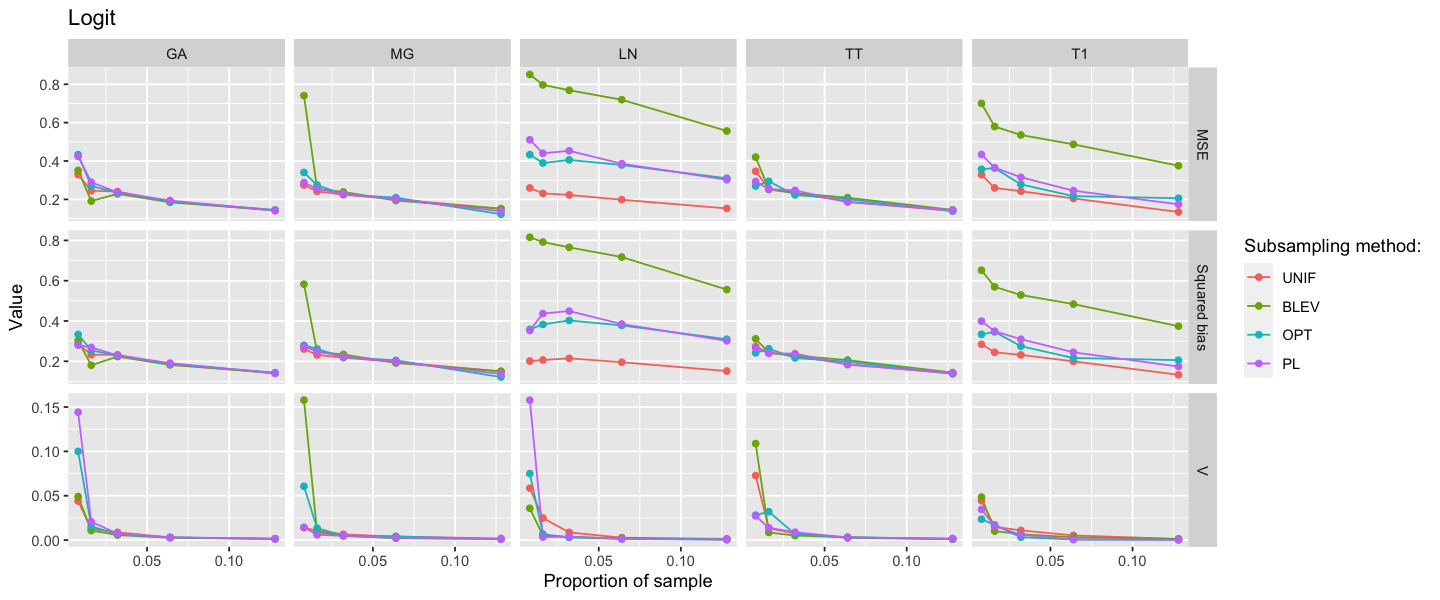

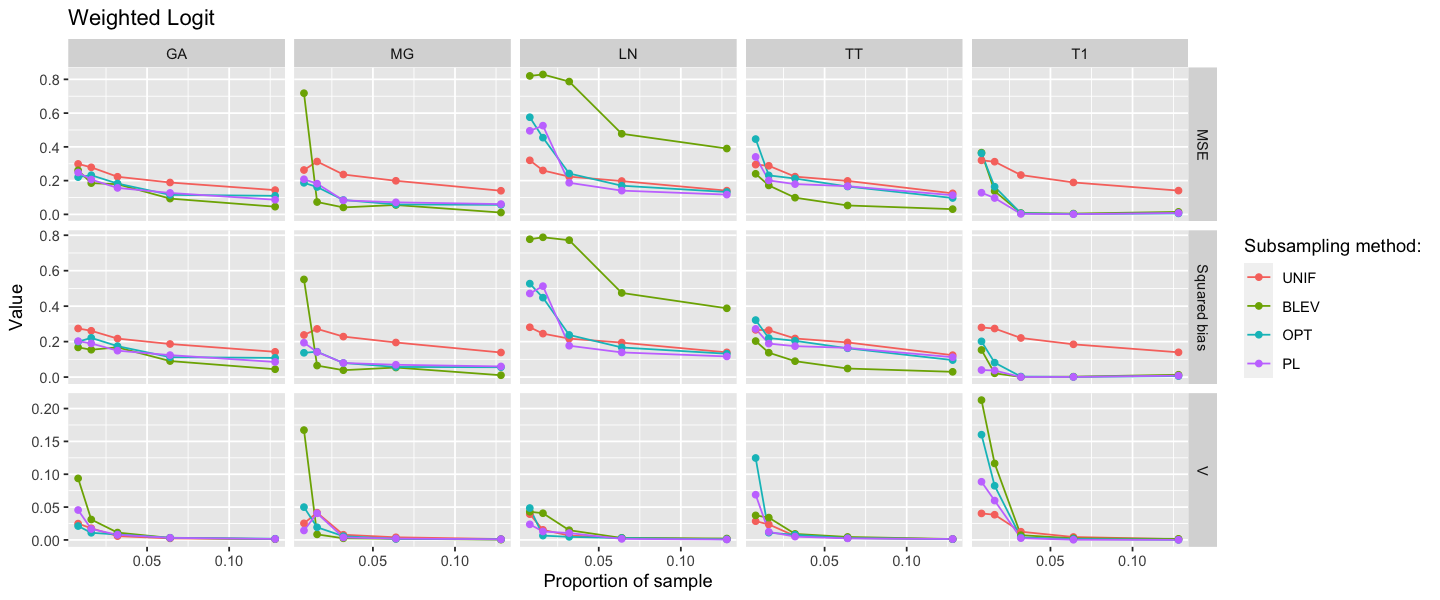

In [34]:
grid_search <- readRDS("outputs/grid_search_logit.rds")
p_list <- lapply(
  1:2,
  function(i) {
    ggplot(
      data=grid_search[weighted==levels(weighted)[i]], 
      aes(x=m, y=value, colour=method)
    ) +
      geom_line() +
      geom_point() +
      facet_grid(
        rows = vars(variables),
        cols = vars(data_set),
        scales = "free_y"
      ) +
      scale_color_discrete(
        name="Subsampling method:"
      ) +
      labs(
        x="Proportion of sample",
        y="Value",
        title=levels(grid_search$weighted)[i]
      ) 
  }
)
names(p_list) <- levels(grid_search$weighted)
p_list

### Real data example

Until now we have merely shown that non-uniform undersampling can lead to better approximations of $\hat\beta_n$ for logistic regression. But ultimately the goal in classification problems is to accurately predict $y$ from test data. The results so far offer a promising start: it appears that we have mitigated a common issue associated with *random* undersampling which we already flagged above - loss of important observations. To investigate if this also leads to better out-of-sample predictions we will next turn to real data.

A number of interesting data sets related to COVID-19 have been made publicly available for research. An interesting data set for our purposes that contains information about individual patients is being maintained for the [Open COVID-19 Data Working Group](https://github.com/beoutbreakprepared/nCoV2019). The methodology for building the data set was originally developed by was developed by @xu2020Epidemiological. Information about how the data is being maintained and updated can be found in @kraemer2020epidemiological. 
The complete data set is vast, but for our purposes we are only interested in the subset of data that contains information about the patient's outcome state. The subset of the data we will use for our prediction exercise here is shown below. It contains the patient outcome variable $y\in \{0=\text{survived}, 1=\text{deceased}\}$ which we are interested in predicting from a set of features: age, gender and geographical location. The model is kept intentionally simple, as our goal here continues to be the evaluation of subsampling methods, rather than building an accurate prediction. 

In [38]:
dt <- readRDS("data/dt_preprocessed.rds")
head(dt)

patient_id,age,sex,latitude,longitude,y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,78,0,45.297748,11.65838,1
2,61,1,1.353460,103.81510,0
3,28,0,1.353460,103.81510,0
4,56,1,1.353460,103.81510,0
5,79,1,1.353873,103.86048,0
6,26,0,1.353460,103.81510,0
